In [1]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

import numpy as np
import pandas as pd
import itertools
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import *
from lightgbm import LGBMClassifier

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
%matplotlib inline

In [2]:
def get_auc_scores(clf, X_train, X_test, y_train, y_test):
    '''Prints the AUC scores for training and testing data
    and returns testing score'''

    y_train_score = clf.predict_proba(X_train)[:, 1]
    y_test_score = clf.predict_proba(X_test)[:, 1]
    print('Training AUC:' , roc_auc_score(y_train, y_train_score))
    print('Testing AUC: ', roc_auc_score(y_test, y_test_score))
 
    return y_test_score

def plot_roc_curve(y_test, y_test_score):
    '''Plot ROC curve for testing data'''
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], 'k — ')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='lower right')
    plt.show()

#https://medium.com/swlh/how-to-code-and-evaluate-of-decision-trees-2d94093b3c1a

In [3]:
## fix random seed
import random
random.seed(222)

# Data Preprocessing

In [4]:
path = pd.read_csv("../Data/cleansed_final.csv")

In [5]:
final = path[["MSI","Under50","TILS", "Stage12", "Signet", "RightSide","NoNecrosis", "Mucin", "ModDiff", "HistHet", "Female", "Expansile", "CrohnMissing", "Crohn", "AngioLymph"]]

In [6]:
final.corr()

,MSI,Under50,TILS,Stage12,Signet,RightSide,NoNecrosis,Mucin,ModDiff,HistHet,Female,Expansile,CrohnMissing,Crohn,AngioLymph
MSI,1.000000,0.016604,0.254277,0.054910,0.092552,0.193266,0.236852,0.191733,0.259828,0.092695,0.071438,0.110845,0.044430,0.071424,0.004327
Under50,0.016604,1.000000,-0.031544,-0.065956,0.031272,-0.033558,0.009924,-0.003553,0.000703,0.019226,0.071099,-0.105421,-0.014788,-0.002096,0.065491
TILS,0.254277,-0.031544,1.000000,0.145131,0.014077,0.139370,0.216396,0.201026,0.279354,0.117937,0.002330,0.211644,-0.004162,0.141986,-0.122893
Stage12,0.054910,-0.065956,0.145131,1.000000,-0.095906,0.029547,-0.011021,0.004360,-0.029065,-0.077724,-0.034166,0.245760,0.045722,0.097821,-0.262233
Signet,0.092552,0.031272,0.014077,-0.095906,1.000000,0.065117,0.237065,0.148202,0.230998,0.197953,0.026323,-0.030985,-0.001004,-0.005464,0.159666
RightSide,0.193266,-0.033558,0.139370,0.029547,0.065117,1.000000,0.125062,0.150758,0.170959,0.119610,0.081890,0.086323,0.033216,0.088632,0.008884
NoNecrosis,0.236852,0.009924,0.216396,-0.011021,0.237065,0.125062,1.000000,0.425246,0.494461,0.145757,0.045354,0.114346,0.021402,0.017174,0.036437
Mucin,0.191733,-0.003553,0.201026,0.004360,0.148202,0.150758,0.425246,1.000000,0.363871,0.241524,0.060469,0.155596,0.053415,0.007660,-0.031113
ModDiff,0.259828,0.000703,0.279354,-0.029065,0.230998,0.170959,0.494461,0.363871,1.000000,0.155940,0.023690,0.115039,0.070173,0.015696,0.044423
HistHet,0.092695,0.019226,0.117937,-0.077724,0.197953,0.119610,0.145757,0.241524,0.155940,1.000000,0.005980,-0.014575,-0.018499,0.046165,0.136273


In [7]:
y = final["MSI"]
X = final.loc[:, final.columns != 'MSI']

In [8]:
## train test val
## 81 : 9 : 10
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1)

In [9]:
X_test

,Under50,TILS,Stage12,Signet,RightSide,NoNecrosis,Mucin,ModDiff,HistHet,Female,Expansile,CrohnMissing,Crohn,AngioLymph
828,0,1,1,0,1,0,0,1,0,1,0,1,0,0
137,0,0,1,0,1,0,0,0,0,1,0,0,1,0
1420,0,0,0,0,0,0,0,1,0,0,0,0,0,0
267,0,0,1,0,0,0,1,1,1,0,0,0,0,1
186,0,0,0,0,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,0,1,1,0,0,0,0,0,0,0,0,0,1,1
1824,0,0,0,0,0,0,0,0,0,0,0,0,0,1
895,0,0,1,0,0,0,0,0,0,1,1,0,0,0
285,0,0,0,0,1,0,0,0,0,1,0,0,1,0


In [10]:
# ## train_test split
# X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=.3, random_state=1)

In [11]:
# X_train_dum = X_train_dum.fillna(X_train_dum.mean())
# X_test_dum = X_test_dum.fillna(X_train_dum.mean())

In [12]:
# sc=MinMaxScaler()
# # sc = StandardScaler()
# X_train_dum = pd.DataFrame(sc.fit_transform(X_train_dum), columns = X_train_dum.columns)
# X_test_dum = pd.DataFrame(sc.transform(X_test_dum), columns = X_test_dum.columns)

In [13]:
## use smote to deal with imbalanced data by oversampling
oversample = SMOTE(random_state = 1)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

# Decistion Tree

In [14]:
## decision tree
clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 100, min_samples_split = 5, min_samples_leaf = 6,  min_weight_fraction_leaf=0.0, max_features=1.0,  random_state=1, min_impurity_decrease=0.005,  min_impurity_split=None,   )
clf = clf.fit(X_smote, y_smote)

Training AUC: 0.7329136867059921
Testing AUC:  0.609037558685446


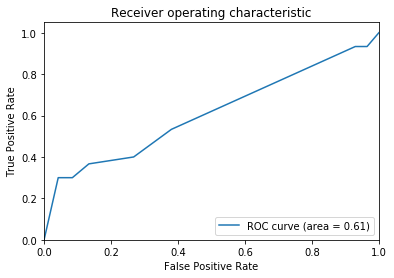

In [15]:
## AUC ROC curve
y_val_score = get_auc_scores(clf, X_smote, X_val, y_smote, y_val)

plot_roc_curve(y_val, y_val_score)

Training AUC: 0.7329136867059921
Testing AUC:  0.6875564588979223


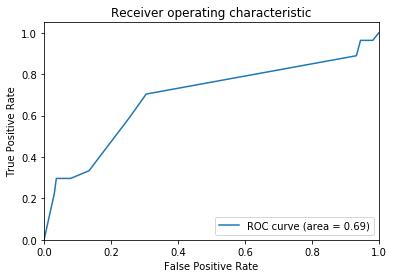

In [16]:
## AUC ROC curve
y_test_score = get_auc_scores(clf, X_smote, X_test, y_smote, y_test)

plot_roc_curve(y_test, y_test_score)

In [17]:
## get feature importance
feature_importance = pd.DataFrame()
feature_importance["value"] = clf.feature_importances_
feature_importance["feature"] = X_smote.columns
feature_importance.sort_values(by = 'value', ascending=False, inplace=True)

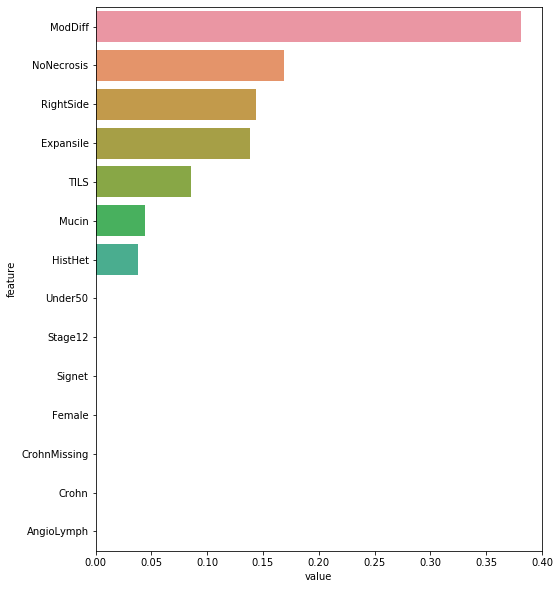

In [18]:
plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="value", data=feature_importance)

# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
forest = RandomForestClassifier(random_state = 1)
modelF = forest.fit(X_smote, y_smote)
y_predF = modelF.predict(X_val)

In [21]:
n_estimators = [100, 300, 500, 800]
max_depth = [3, 4, 5]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_smote, y_smote)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  5.4min finished


In [22]:
print(bestF.best_params_)

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [23]:
forest = RandomForestClassifier(random_state = 1, max_depth =  15, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 800)


In [24]:
forest.fit(X_smote, y_smote)

RandomForestClassifier(max_depth=15, n_estimators=800, random_state=1)

In [25]:
## Accuracy and AUC
print("rf accuracy : ", accuracy_score(forest.predict(X_val), y_val))
print("rf ROC_AUC : ", roc_auc_score(y_val.values, forest.predict_proba(X_val)[:, 1]))

rf accuracy :  0.6395348837209303
rf ROC_AUC :  0.4862676056338028


In [26]:
## Accuracy and AUC
print("rf accuracy : ", accuracy_score(forest.predict(X_test), y_test))
print("rf ROC_AUC : ", roc_auc_score(y_test.values, forest.predict_proba(X_test)[:, 1]))

rf accuracy :  0.6858638743455497
rf ROC_AUC :  0.6044489611562782


Training AUC: 0.9320215264571763
Testing AUC:  0.6044489611562782


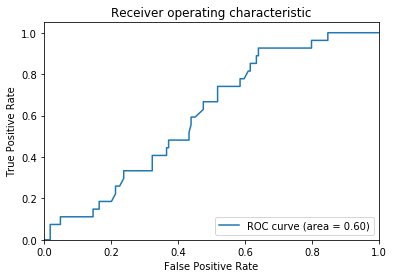

In [37]:
## AUC ROC curve
y_test_score = get_auc_scores(forest, X_smote, X_test, y_smote, y_test)

plot_roc_curve(y_test, y_test_score)

# LightGBM

In [60]:
## LightGBM classifier
# an = []
## hyperparameters from AutoML
lgb = LGBMClassifier(
    objective='binary',
    bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=1e-06, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.7,
               n_estimators=170, n_jobs=-1, num_leaves=50,
               random_state=74, reg_alpha=0.7, reg_lambda=0.005, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## fit
lgb.fit(X_smote,y_smote)
#     if roc_auc_score(y_test_dum.values, lgb.predict_proba(X_test_dum)[:, 1])>0.77:
#         print(i)
#         an.append(i)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.4,
               learning_rate=1e-06, min_child_samples=6, min_split_gain=0.7,
               n_estimators=170, num_leaves=50, objective='binary',
               random_state=74, reg_alpha=0.7, reg_lambda=0.005)

In [61]:
    ## Accuracy and AUC
    print("lgb accuracy : ", accuracy_score(lgb.predict(X_val), y_val))
    print("lgb AUC : ", roc_auc_score(y_val.values, lgb.predict_proba(X_val)[:, 1]))

lgb accuracy :  0.7151162790697675
lgb AUC :  0.6171361502347418


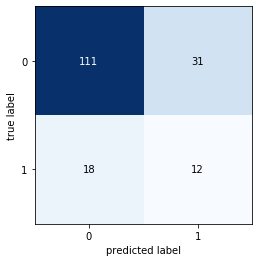

In [62]:
## confusion matrix
fig, ax = plot_confusion_matrix(confusion_matrix(np.array(y_val), 
                       lgb.predict(X_val).tolist()))
plt.show()

In [63]:
## get feature importance
feature_importance = pd.DataFrame()
feature_importance["value"] = lgb.feature_importances_
feature_importance["feature"] = X_smote.columns
feature_importance.sort_values(by = 'value', ascending=False, inplace=True)

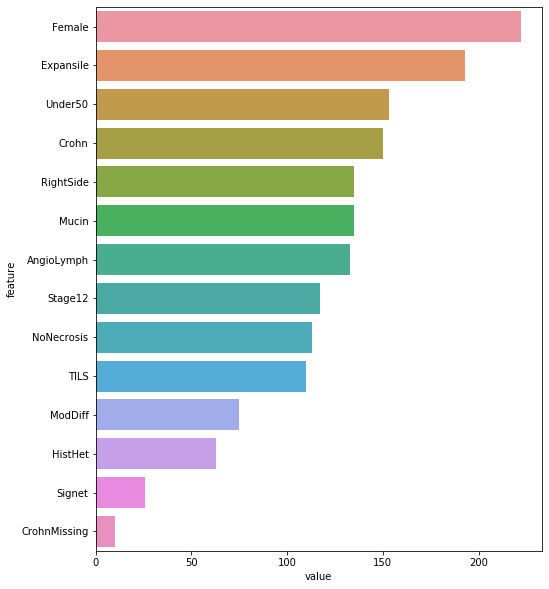

In [64]:
plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="value", data=feature_importance)

In [65]:
feature_importance

,value,feature
9,222,Female
10,193,Expansile
0,153,Under50
12,150,Crohn
4,135,RightSide
6,135,Mucin
13,133,AngioLymph
2,117,Stage12
5,113,NoNecrosis
1,110,TILS


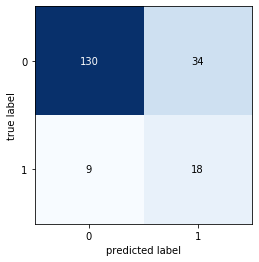

In [66]:
## confusion matrix
fig, ax = plot_confusion_matrix(confusion_matrix(np.array(y_test), 
                       lgb.predict(X_test).tolist()))
plt.show()

Training AUC: 0.7541262708735954
Testing AUC:  0.6171361502347418


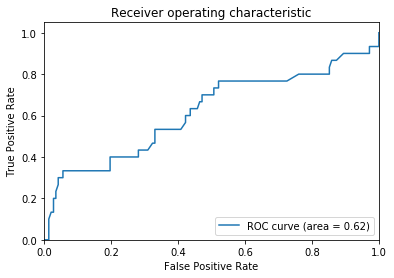

In [67]:
## AUC ROC curve
y_val_score = get_auc_scores(lgb, X_smote, X_val, y_smote, y_val)

plot_roc_curve(y_val, y_val_score)

Training AUC: 0.7541262708735954
Testing AUC:  0.7564363143631436


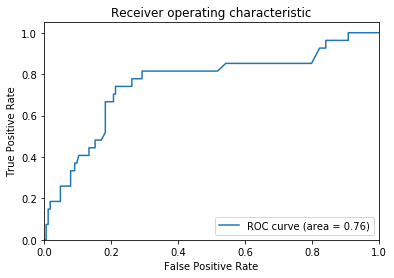

In [68]:
## AUC ROC curve
y_test_score = get_auc_scores(lgb, X_smote, X_test, y_smote, y_test)

plot_roc_curve(y_test, y_test_score)

# XGBoost

In [38]:
import xgboost as xgb

In [73]:
xgb_classifier = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [74]:
xgb_classifier = xgb_classifier.fit(X_smote, y_smote)

[18:48:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/jaeyoung/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training AUC: 0.7185100067827481
Testing AUC:  0.746386630532972


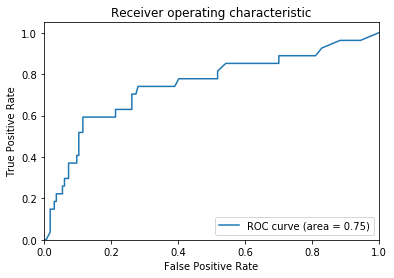

In [76]:
## AUC ROC curve
y_test_score = get_auc_scores(xgb_classifier, X_smote, X_test, y_smote, y_test)

plot_roc_curve(y_test, y_test_score)

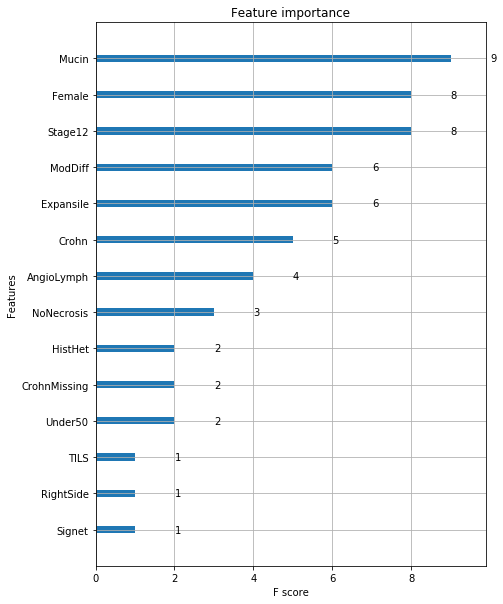

In [82]:
xgb.plot_importance(xgb_classifier)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [83]:
## get feature importance
feature_importance = pd.DataFrame()
feature_importance["value"] = xgb_classifier.feature_importances_
feature_importance["feature"] = X_smote.columns
feature_importance.sort_values(by = 'value', ascending=False, inplace=True)

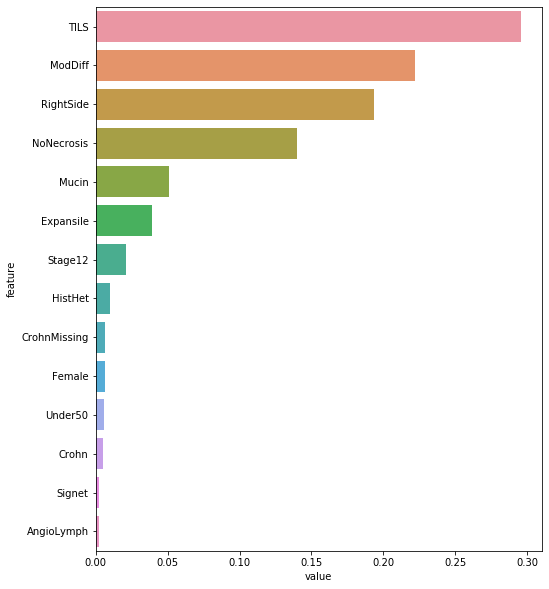

In [84]:
plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="value", data=feature_importance)

In [85]:
feature_importance

,value,feature
1,0.295377,TILS
7,0.221796,ModDiff
4,0.193129,RightSide
5,0.139908,NoNecrosis
6,0.051088,Mucin
10,0.039548,Expansile
2,0.021170,Stage12
8,0.010107,HistHet
11,0.006592,CrohnMissing
9,0.006345,Female
